# Skin lesion classification

**Deadline**: Upload this notebook (rename it as 'TP2-SVM-IMA205-YOUR-SURNAME.ipynb') and the answers to the theoretical questions as a single zip file to the site pédagogique before the 12th of February 2020 (23h59). Name it as 'TP2-SVM-IMA205-YOUR-SURNAME.zip'.

**Context**
A skin lesion is defined as a superficial growth or patch of the skin that is visually different and/or has a different texture than its surrounding area. Skin lesions, such as moles or birthmarks, can degenerate and become melanoma, one of the deadliest skin cancer. Its incidence has been increasing during the last decades, especially in the areas mostly populated by white people.

The most effective treatment is an early detection followed by surgical excision. This is why several approaches for melanoma detection have been proposed in the last years (non-invasive computer-aided diagnosis (CAD) ).


**Goal**
The goal of this practical session is to classify images of skin lesions as either benign or melanoma using machine learning algorithms. In order to do that, you will have at your disposal a set of 30 features already extracted from 600 dermoscopic images (both normal skin lesions and melanoma from the ISIC database - https://isic-archive.com/). These features characterize the Asymmetry, the Border irregularity, the Colour and the Dimension of the lesion (the so-called ABCD rule). 

The features are:
- shape asimmetry (f0 and f1)
- difference in colors between center and periphery of the image (f2, f3, f4, f27, f28, f29)
- geometry (f5, f6, f7)
- other features related to eccentricity,entropy, mean, standard deviation and maximum value of each channel in RGB and HSV (f8,...,f24)
- asimmetry of color intensity (f25, f26)

Features are computed using *manually checked segmentations* and following *Ganster et al. 'Automated melanoma recognition', IEEE TMI, 2001* and *Zortea et al. 'Performance of a dermoscopy-based computer vision system for the diagnosis of pigmented skin lesions compared with visual evaluation by experienced dermatologists', Artificial Intelligence in Medicine, 2014*.

First load all necessary packages

In [0]:
import os
import numpy as np
import pandas as pd
from skimage.io import imread
from time import time
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  cross_val_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

np.random.seed(4)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

# Code from scikit-learn
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Then load the data from my Google Drive

In [0]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='18hrQVGBCfW7SKTnzmWUONo8iowBsi1DL',
dest_path='./data/features.csv')
gdd.download_file_from_google_drive(file_id='1iQZdUiuK_FwZ7mik7LB3eN_H_IUc5l7b',
dest_path='./data/im/nevus-seg.jpg')
gdd.download_file_from_google_drive(file_id='1_TeYzLLDoKbPX4xXAOAM_mQiT2nLHgvp',
dest_path='./data/im/nevus.jpg')
gdd.download_file_from_google_drive(file_id='1B2Ol92mBcHN6ah3bpoucBbBbHkPMGC8D',
dest_path='./data/im/melanoma-seg.jpg')
gdd.download_file_from_google_drive(file_id='1yZ46UzGhwO7g5T8397JpewBl6UqgRo5J',
dest_path='./data/im/melanoma.jpg')

Or from yout local computer. Please download the 'data' folder in the same folder as your notebook and do not modifiy it.

Then read the data 

In [3]:
## Read data
Working_directory="./data/" 
df = pd.read_csv(Working_directory + 'features.csv') # reading data
y = df['Malignant'].values # 1 for Melanoma and 0 for healthy
class_names = ["healthy","melanoma"]
X = df.iloc[:,3:33].values # Features
N,M=X.shape
print('Number of images: {0}; Number of features per image: {1}'.format(N,M))
print('Number of healthy nevus: {0}; Number of melanoma: {1}'.format(N-np.sum(y), np.sum(y)))


Number of images: 600; Number of features per image: 30
Number of healthy nevus: 485; Number of melanoma: 115


Two examples of healthy nevus and melanoma


Text(0.5, 1.0, 'Segmented melanoma')

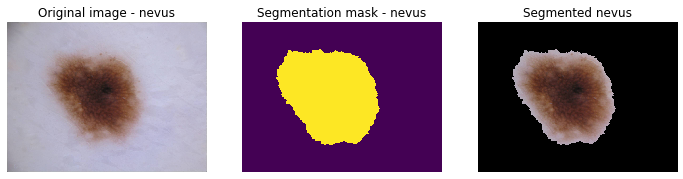

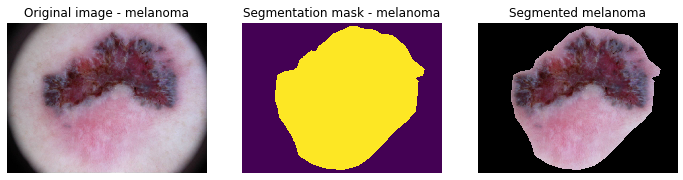

In [4]:
## Plot two examples of nevus and melanoma
print('Two examples of healthy nevus and melanoma')
nevus = imread(Working_directory + 'im/nevus.jpg')
nevus_Segmentation = imread(Working_directory + 'im/nevus-seg.jpg') 
nevus_Segmentation_boolean = (nevus_Segmentation/255).astype(np.uint8) # To get uint8 (integer numbers)
nevus_Segmentation_3D = np.expand_dims(nevus_Segmentation_boolean, axis=2) # To have a binary mask for the three channels (RGB)
nevus_mul_mask = (nevus_Segmentation_3D*nevus) # we apply the binary mask to all channels pixel-wise

fig = plt.figure(figsize=(12, 12)) # size of the figure
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5) # code to create subplots
grid[0].imshow(nevus)
grid[0].axis('off')
grid[0].set_title('Original image - nevus')
grid[1].imshow(nevus_Segmentation)
grid[1].axis('off')
grid[1].set_title("Segmentation mask - nevus")
grid[2].imshow(nevus_mul_mask)
grid[2].axis('off')
grid[2].set_title("Segmented nevus")

###

melanoma = imread(Working_directory + 'im/melanoma.jpg')
melanoma_Segmentation = imread(Working_directory + 'im/melanoma-seg.jpg') 
melanoma_Segmentation_boolean = (melanoma_Segmentation/255).astype(np.uint8) # To get uint8 (integer numbers)
melanoma_Segmentation_3D = np.expand_dims(melanoma_Segmentation_boolean, axis=2) # To have a binary mask for the three channels (RGB)
melanoma_mul_mask = (melanoma_Segmentation_3D*melanoma) # we apply the binary mask to all channels pixel-wise

fig = plt.figure(figsize=(12, 12)) # size of the figure
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5) # code to create subplots
grid[0].imshow(melanoma)
grid[0].axis('off')
grid[0].set_title('Original image - melanoma')
grid[1].imshow(melanoma_Segmentation)
grid[1].axis('off')
grid[1].set_title("Segmentation mask - melanoma")
grid[2].imshow(melanoma_mul_mask)
grid[2].axis('off')
grid[2].set_title("Segmented melanoma")


Now, as in the previous practical session you should shuffle the data randomly

In [0]:
# Shuffle data randomly
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X_shuffled = X[indices]
y_shuffled = y[indices]

As we have already seen, it might be very important to scale the data such that each feature has, for instance, average equal to 0 and unit variance.

In [0]:
# Scale data (each feature will have average equal to 0 and unit variance)
scaler = StandardScaler()
scaler.fit(X_shuffled)
X_scaled = scaler.transform(X_shuffled)

We should now test the discriminative power of our features. Let divide the entire data-set into training and test set and use two simple classification algorithms, a linear and a quadratic one... Look at the confusion matrices and comment the results. 

Normalized confusion matrix
[[0.93 0.07]
 [0.65 0.35]]


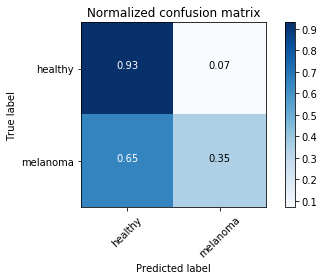

In [7]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_shuffled, test_size=0.20, random_state=4)

# Fitting linear
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred_lda = lda.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_lda)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Normalized confusion matrix
[[0.91 0.09]
 [0.85 0.15]]


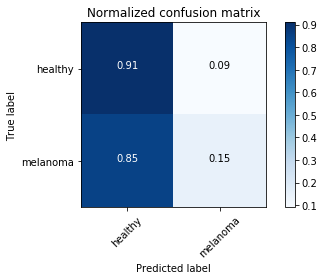

In [8]:
# Fitting quadratic
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)
y_pred_qda = qda.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_qda)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

**The confusion matrices show that the features we chose are not very discriminant, as regards the linear and quadratic discriminant analysis. Indeed, we can note that most images are classified 'healthy' whether they are or not, which causes huge problem in pratice (false negative, leading to skin cancer not detected).**

**We should try and choose a new method or new features.**

The results you obtained are based on a precise subdivision of your data into training and test. This can thus bias your results. Which technique could you use instead ? Test it with at least three different models (e.g. LDA, QDA, K-NN, etc)

**One could use cross-validation on the whole data set, which would help us not have any sort of bias regarding the size of the training and testing sets, as all the folds would be considered before fitting the data.**

In [9]:
# Fitting LDA
lda = LinearDiscriminantAnalysis()
lda_score = cross_val_score(lda, X_scaled, y_shuffled, cv=5)
print("LDA: Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std()))

# Fitting QDA
qda = QuadraticDiscriminantAnalysis()
qda_score = cross_val_score(qda, X_scaled, y_shuffled, cv=5)
print("QDA: Average and std CV score : {0} +- {1}".format(qda_score.mean(), qda_score.std()))

# Fitting K-NN
neigh = KNeighborsClassifier(n_neighbors=5)
neigh_score = cross_val_score(neigh, X_scaled, y_shuffled, cv=5)
print("KNN: Average and std CV score : {0} +- {1}".format(neigh_score.mean(), neigh_score.std()))

LDA: Average and std CV score : 0.8150000000000001 +- 0.029533408577782257
QDA: Average and std CV score : 0.8016666666666665 +- 0.01999999999999997
KNN: Average and std CV score : 0.825 +- 0.03291402943021918


When using K-NN, instead than fixing the number of nearest neighbours, we could also estimate the best value. Do it and plot the confusion matrix. Do you notice anything strange ? 

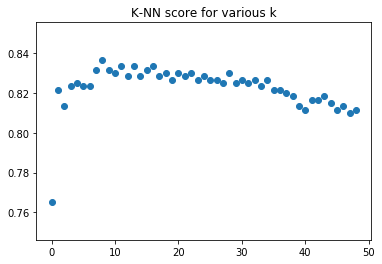

 
The best K we can choose for K-NN is k = 9


In [10]:
list_score =[]
for k in range(1, 50):
  neigh = KNeighborsClassifier(n_neighbors=k)
  neigh_score = cross_val_score(neigh, X_scaled, y_shuffled, cv=5)
  list_score+=[neigh_score.mean()]

x = np.array(range(len(list_score)))
y = np.array(list_score)

plt.scatter(x, y)
plt.title("K-NN score for various k")
plt.show()

best_k = np.argmax(y)+1 # array starts at 0 but k starts at 1

print(" ")
print("The best K we can choose for K-NN is k =", best_k)

**We then have that the best $K$ possibly chosen for $K$-NN is $K = 9$. We plot the CV score and the confusion matrix for this value.**


Normalized confusion matrix
[[0.97 0.03]
 [0.75 0.25]]


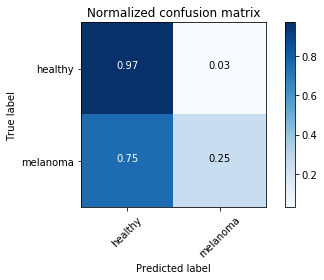

In [11]:
# Fitting K-NN
neigh = KNeighborsClassifier(n_neighbors=best_k)
neigh.fit(X_train, y_train)
y_pred_neigh = neigh.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_neigh)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

**This choice of $K$ allows us to get an excellent result for healthy beauty spots. However, we also get a 75% chance of getting the label 'healthy' when looking at a melanoma, which is very poor.**

**Whatever the input, the code returns almost always healthy, which shows that either the method we use here is not working, or that there is a bias we did not consider.**

I strongly suggest that you look at these two web-pages: 
- https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter, and try other scoring functions with at least one of the 3 previous models.
- https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html and try at least one naive random over-sampling (look at the following code...).

In [12]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_shuffled, test_size=0.33, random_state=2)
ros = RandomOverSampler(random_state=4)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))

[(0, 326), (1, 326)]


Let's retest KNN on this new data-set. Are the results better ?

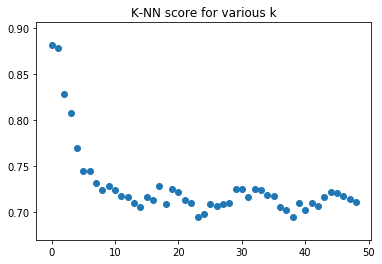

 
The best K we can choose for K-NN is k = 1
Normalized confusion matrix
[[0.8427673  0.1572327 ]
 [0.69230769 0.30769231]]


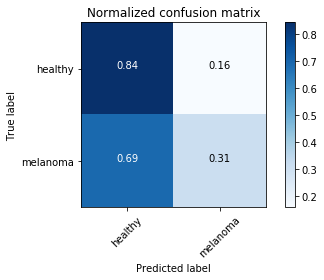

In [13]:
## Using resampled variables

# Looking for the best k 

list_score =[]

for k in range(1, 50):
  neigh = KNeighborsClassifier(n_neighbors=k)
  neigh_score = cross_val_score(neigh, X_resampled, y_resampled, cv=5)
  list_score+=[neigh_score.mean()]

x = np.array(range(len(list_score)))
y = np.array(list_score)

plt.scatter(x, y)
plt.title("K-NN score for various k")
plt.show()

best_k = np.argmax(y)+1 # array starts at 0 but k starts at 1

print(" ")
print("The best K we can choose for K-NN is k =", best_k)

# Fitting K-NN
neigh = KNeighborsClassifier(n_neighbors=best_k)
neigh.fit(X_resampled, y_resampled)
y_pred_neigh = neigh.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_neigh)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

**The new $K$ with these resampled variables is $K = 1$. The results are more or less the same, i.e. not quite good.**

**We shall then try other methods a bit less 'naive'.**

Let's use more advanced techiques such as SVM

In [14]:
# Fitting Linear SVM on original data
print("Fitting Linear SVM to the training set")
t0 = time()
Lsvm = LinearSVC(class_weight='balanced') # class_weight needs to be set as balanced when classes are imabalanced > https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
Lsvm_score = cross_val_score(Lsvm, X_resampled, y_resampled, cv=5, scoring='balanced_accuracy')
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))

Fitting Linear SVM to the training set
done in 0.264s
 Average and std CV score : 0.8150000000000001 +- 0.029533408577782257


Suppose that there are overlapping classes, we need to set the hyper-parameter C. Use Cross-Validation to find the best C value.

The best C is 10.0  with an average validation score equal to  0.7285965942454492
Normalized confusion matrix
[[0.75471698 0.24528302]
 [0.43589744 0.56410256]]


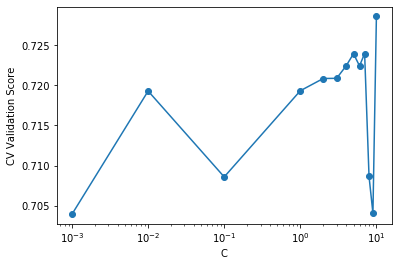

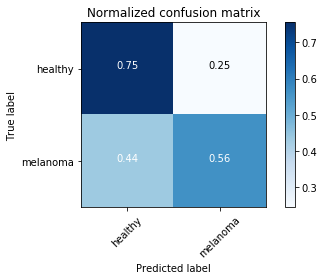

In [15]:
# Looking for the best hyperparameter C 
p_grid_lsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1]}
Lsvm = LinearSVC(class_weight='balanced')
grid = GridSearchCV(Lsvm, p_grid_lsvm, cv=5, n_jobs=-1)
grid.fit(X_resampled, y_resampled)

print('The best C is', grid.best_params_.get('C'), ' with an average validation score equal to ', grid.best_score_)

# plot the CV validation score for each C value
plt.plot([1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1], grid.cv_results_.get('mean_test_score'), marker='o')
plt.xscale("log")
plt.xlabel('C')
plt.ylabel('CV Validation Score')

# Fitting (SVM)
Lsvm = LinearSVC(class_weight='balanced', C=grid.best_params_.get('C'))
Lsvm.fit(X_resampled, y_resampled)
y_pred_lsvm = Lsvm.predict(X_test)

# Compute confusion matrix
cnf_matrix_lsvm = confusion_matrix(y_test, y_pred_lsvm)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_lsvm, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

**Here, we have a result that seems more coherent than before: the melanoma are mostly classified as so, and vice-versa. The score is still weak though.**

Try to use the previous SVM code but on the over-sampled data. Does the scoring result change ? 

The best C is 10.0  with an average validation score equal to  0.7433333333333334
Normalized confusion matrix
[[0.86792453 0.13207547]
 [0.38461538 0.61538462]]


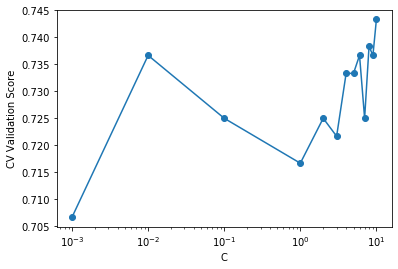

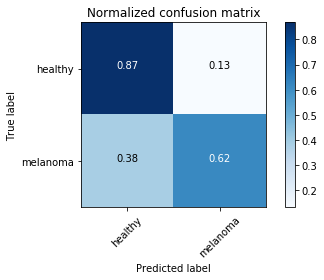

In [16]:
# Fitting Linear SVM on over-sampled data
# Looking for the best hyperparameter C 
p_grid_lsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1]}
Lsvm = LinearSVC(class_weight='balanced')
grid = GridSearchCV(Lsvm, p_grid_lsvm, cv=5, n_jobs=-1)
grid.fit(X_scaled, y_shuffled)

print('The best C is', grid.best_params_.get('C'), ' with an average validation score equal to ', grid.best_score_)

# plot the CV validation score for each C value
plt.plot([1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1], grid.cv_results_.get('mean_test_score'), marker='o')
plt.xscale("log")
plt.xlabel('C')
plt.ylabel('CV Validation Score')

# Fitting (SVM)
Lsvm = LinearSVC(class_weight='balanced', C=grid.best_params_.get('C'))
Lsvm.fit(X_scaled, y_shuffled)
y_pred_lsvm = Lsvm.predict(X_test)

# Compute confusion matrix
cnf_matrix_lsvm = confusion_matrix(y_test, y_pred_lsvm)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_lsvm, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

**The confusion matrix is slighlty better, and the scoring remains overall the same here.**

Here it is the code for non-linear SVM using radial basis function. We need to tune another hyper-parameter $gamma$. We look for the best $C$ and $gamma$ at the same time.

In [17]:
# Fitting Non-linear SVM
print("Fitting Non-linear SVM to the training set")
t0 = time()
p_grid_nlsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
NLsvm = SVC(kernel='rbf', class_weight='balanced')
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Nested CV with parameter optimization
clf = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, cv=inner_cv)
nested_score = cross_val_score(clf, X_resampled, y_resampled, cv=outer_cv)
print("done in %0.3fs" % (time() - t0))
print("Average and std Nested Cv score : {0} +- {1}".format(nested_score.mean(), nested_score.std()))

# Looking for the best hyperparameters
grid_nlsvm = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, scoring="balanced_accuracy", cv=5)
grid_nlsvm.fit(X_resampled, y_resampled)
print("Best Score: {}".format(grid_nlsvm.best_score_))
print("Best params: {}".format(grid_nlsvm.best_params_))


Fitting Non-linear SVM to the training set
done in 26.976s
Average and std Nested Cv score : 0.9632530827950676 +- 0.01887898949849937
Best Score: 0.9631235431235432
Best params: {'C': 2, 'gamma': 0.1}


Another important point is the importance of the single features.
The more naive technique would be to test each feature independently in a greedy fashion called sequential forward feature selection. Starting from an empty set and a classification model, you will first add the feature that maximizes a certain criterion (i.e. balanced accuracy). Then, you will iterate this process until a chosen stopping criterion by adding at each iteration only the best feature. Each feature can be added of course only once. You could also use the opposite process by removing at each iteraton the least important feature starting from the entire set of features (i.e. sequential backward feature selection). Implement at least one of these ideas. 

In [18]:
## Implementing forward feature selection with a non-linear SVM

scores = []
for index in range(X_resampled.shape[1]):
  
  # Fitting Non-linear SVM
  NLsvm = SVC(C = 2.0, gamma = 0.1, kernel = "rbf", class_weight = "balanced")
  NLsvm.fit(X_resampled[::, index].reshape(-1,1), y_resampled)
  
  # Predicting regarding the feature index and getting its score
  y_pred = NLsvm.predict(X_test[::,index].reshape(-1,1))
  scores.append(balanced_accuracy_score(y_test, y_pred))

# Finding the best features
best_features = []
threshold = 0.6 # score threshold under which we consider a variable to be insignificant

best_features = [i for i, scoring in enumerate(scores) if scoring>threshold]

print(" The features we decide to keep are:", best_features)

 The features we decide to keep are: [6, 18, 25, 27, 28, 29]


**Having isolated the 'best' features, we can then perform our training methods using new variables taking only these features into account.**